# Tujuan Proyek

Proyek ini bertujuan untuk melakukan **analisis sentimen pada komentar YouTube** yang membahas isu warga rela menyerahkan data retina demi uang. Dengan menggunakan **algoritma Support Vector Machine (SVM)**, penelitian ini diharapkan mampu memberikan gambaran objektif mengenai opini publik, apakah cenderung positif, negatif, atau netral.  

Notebook ini dibuat oleh **Danendra Shafi Athallah**.


# ***CRAWLING DATA***

In [ ]:
from googleapiclient.discovery import build
import csv
import pandas as pd

# Masukkan API Key yang didapat dari Google Cloud Console
api_key = "MASUKKAN_API_KEY_DI_SINI"
youtube = build('youtube', 'v3', developerKey=api_key)

# Fungsi untuk mengambil komentar dari video
def get_video_comments(video_id, max_comments):
    comments = []
    next_page_token = None

    while len(comments) < max_comments:
        response = youtube.commentThreads().list(
            part='snippet',
            videoId=video_id,
            maxResults=2000,
            textFormat='plainText',
            pageToken=next_page_token
        ).execute()

        for item in response['items']:
            if len(comments) >= max_comments:
                break
            comment = item['snippet']['topLevelComment']['snippet']['textDisplay']
            author = item['snippet']['topLevelComment']['snippet']['authorDisplayName']
            like_count = item['snippet']['topLevelComment']['snippet']['likeCount']
            published_at = item['snippet']['topLevelComment']['snippet']['publishedAt']

            comments.append({
                'author': author,
                'comment': comment,
                'likes': like_count,
                'published_at': published_at
            })

        next_page_token = response.get('nextPageToken')
        if not next_page_token:
            break

    return comments[:max_comments]

# Fungsi untuk menyimpan komentar ke file CSV
def save_comments_to_csv(comments, filename):
    with open(filename, mode='w', newline='', encoding='utf-8') as file:
        writer = csv.DictWriter(file, fieldnames=['author', 'comment', 'likes', 'published_at'])
        writer.writeheader()
        writer.writerows(comments)

# Fungsi utama untuk mengambil komentar dari beberapa video
def scrape_comments_from_videos(video_ids, total_comments, output_filename):
    all_comments = []
    comments_per_video = total_comments // len(video_ids)

    for video_id in video_ids:
        comments = get_video_comments(video_id, comments_per_video)
        all_comments.extend(comments)

    # Jika masih kurang, tambahkan sisanya dari video pertama
    if len(all_comments) < total_comments:
        extra_comments = total_comments - len(all_comments)
        extra_comments_from_first = get_video_comments(video_ids[0], extra_comments)
        all_comments.extend(extra_comments_from_first[:extra_comments])

    # Simpan hasilnya ke file CSV
    save_comments_to_csv(all_comments, output_filename)
    return all_comments

In [3]:
# ID video YouTube yang ingin diambil
video_ids = ['pymLtyhZgGc']
total_comments = 1000
output_filename = 'dataRetina.csv'

# Ambil komentar dan simpan ke file CSV
comments = scrape_comments_from_videos(video_ids, total_comments, output_filename)

df = pd.DataFrame(comments)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750 entries, 0 to 749
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   author        750 non-null    object
 1   comment       750 non-null    object
 2   likes         750 non-null    int64 
 3   published_at  750 non-null    object
dtypes: int64(1), object(3)
memory usage: 23.6+ KB


,author,comment,likes,published_at
0,@RizkyPratama-j1u,RAKYAT MISKIN DI INDONESIA \n90 PERSEN....AKIB...,0,2025-05-12T12:22:44Z
1,@masturmeot8797,Gw ikut tuh.. gw percaya Sam altman orang bai...,0,2025-05-12T08:46:44Z
2,@JimmyWijaya-v3p,Lebay gak berkwalitas berita rendah \nTempat u...,0,2025-05-11T21:25:29Z
3,@Neon77Jep,Metro tv mau bangkrut mau minta jatah sm world 😅,0,2025-05-10T11:01:10Z
4,@Anoy-q3s,Indonesia Emas 🤣🤣🤣,0,2025-05-10T09:48:45Z


# ***PREPROCESSING DATA***

In [4]:
import pandas as pd

data = pd.read_csv("dataRetina.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750 entries, 0 to 749
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   author        750 non-null    object
 1   comment       750 non-null    object
 2   likes         750 non-null    int64 
 3   published_at  750 non-null    object
dtypes: int64(1), object(3)
memory usage: 23.6+ KB


In [5]:
data.head(5)

,author,comment,likes,published_at
0,@RizkyPratama-j1u,RAKYAT MISKIN DI INDONESIA \n90 PERSEN....AKIB...,0,2025-05-12T12:22:44Z
1,@masturmeot8797,Gw ikut tuh.. gw percaya Sam altman orang bai...,0,2025-05-12T08:46:44Z
2,@JimmyWijaya-v3p,Lebay gak berkwalitas berita rendah \nTempat u...,0,2025-05-11T21:25:29Z
3,@Neon77Jep,Metro tv mau bangkrut mau minta jatah sm world 😅,0,2025-05-10T11:01:10Z
4,@Anoy-q3s,Indonesia Emas 🤣🤣🤣,0,2025-05-10T09:48:45Z


In [6]:
df  = pd.DataFrame(data[['comment']])
df.head(5)

,comment
0,RAKYAT MISKIN DI INDONESIA \n90 PERSEN....AKIB...
1,Gw ikut tuh.. gw percaya Sam altman orang bai...
2,Lebay gak berkwalitas berita rendah \nTempat u...
3,Metro tv mau bangkrut mau minta jatah sm world 😅
4,Indonesia Emas 🤣🤣🤣


**PROSES HAPUS DATA DUPLIKAT**

---



In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750 entries, 0 to 749
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   comment  750 non-null    object
dtypes: object(1)
memory usage: 6.0+ KB


In [8]:
df.drop_duplicates(subset ="comment", keep = 'first', inplace = True)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 374 entries, 0 to 374
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   comment  374 non-null    object
dtypes: object(1)
memory usage: 5.8+ KB


**PROSES CLEANING**

---



In [10]:
import re
import string
import nltk

# Fungsi untuk menghapus URL
def remove_URL(tweet):
    if tweet is not None and isinstance(tweet, str):
        url = re.compile(r'https?://\S+|www\.\S+')
        return url.sub(r'', tweet)
    else:
        return tweet

# Fungsi untuk menghapus HTML
def remove_html(tweet):
    if tweet is not None and isinstance(tweet, str):
        html = re.compile(r'<.*?>')
        return html.sub(r'', tweet)
    else:
        return tweet

# Fungsi untuk menghapus emoji
def remove_emoji(tweet):
    if tweet is not None and isinstance(tweet, str):
        emoji_pattern = re.compile("["
            u"\U0001F600-\U0001F64F"  # emoticons
            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
            u"\U0001F680-\U0001F6FF"  # transport & map symbols
            u"\U0001F700-\U0001F77F"  # alchemical symbols
            u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
            u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
            u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
            u"\U0001FA00-\U0001FA6F"  # Chess Symbols
            u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
            u"\U0001F004-\U0001F0CF"  # Additional emoticons
            u"\U0001F1E0-\U0001F1FF"  # flags
                               "]+", flags=re.UNICODE)
        return emoji_pattern.sub(r'', tweet)
    else:
        return tweet

# Fungsi untuk menghapus simbol
def remove_symbols(tweet):
    if tweet is not None and isinstance(tweet, str):
        tweet = re.sub(r'[^a-zA-Z0-9\s]', '', tweet)
    return tweet

# Fungsi untuk menghapus angka
def remove_numbers(tweet):
    if tweet is not None and isinstance(tweet, str):
        tweet = re.sub(r'\d', '', tweet)
    return tweet

# Fungsi hapus username
def remove_usernames(text):
    return re.sub(r'@\w+', '', text)

df['cleaning'] = df['comment'].apply(lambda x: remove_URL(x))
df['cleaning'] = df['cleaning'].apply(lambda x: remove_usernames(x))
df['cleaning'] = df['cleaning'].apply(lambda x: remove_html(x))
df['cleaning'] = df['cleaning'].apply(lambda x: remove_emoji(x))
df['cleaning'] = df['cleaning'].apply(lambda x: remove_symbols(x))
df['cleaning'] = df['cleaning'].apply(lambda x: remove_numbers(x))

df.head(5)

,comment,cleaning
0,RAKYAT MISKIN DI INDONESIA \n90 PERSEN....AKIB...,RAKYAT MISKIN DI INDONESIA \n PERSENAKIBAT DIK...
1,Gw ikut tuh.. gw percaya Sam altman orang bai...,Gw ikut tuh gw percaya Sam altman orang baik ...
2,Lebay gak berkwalitas berita rendah \nTempat u...,Lebay gak berkwalitas berita rendah \nTempat u...
3,Metro tv mau bangkrut mau minta jatah sm world 😅,Metro tv mau bangkrut mau minta jatah sm world
4,Indonesia Emas 🤣🤣🤣,Indonesia Emas


**PROSES CASE FOLDING**

---



In [11]:
def case_folding(text):
    if isinstance(text, str):
        lowercase_text = text.lower()
        return lowercase_text
    else:
        return text

df['case_folding'] = df['cleaning'].apply(case_folding)
df.head(5)

,comment,cleaning,case_folding
0,RAKYAT MISKIN DI INDONESIA \n90 PERSEN....AKIB...,RAKYAT MISKIN DI INDONESIA \n PERSENAKIBAT DIK...,rakyat miskin di indonesia \n persenakibat dik...
1,Gw ikut tuh.. gw percaya Sam altman orang bai...,Gw ikut tuh gw percaya Sam altman orang baik ...,gw ikut tuh gw percaya sam altman orang baik ...
2,Lebay gak berkwalitas berita rendah \nTempat u...,Lebay gak berkwalitas berita rendah \nTempat u...,lebay gak berkwalitas berita rendah \ntempat u...
3,Metro tv mau bangkrut mau minta jatah sm world 😅,Metro tv mau bangkrut mau minta jatah sm world,metro tv mau bangkrut mau minta jatah sm world
4,Indonesia Emas 🤣🤣🤣,Indonesia Emas,indonesia emas


**Normalisasi Kata**

---



In [12]:
import pandas as pd
import requests
from io import BytesIO

# Fungsi penggantian kata tidak baku
def replace_taboo_words(text, kamus_tidak_baku):
    if isinstance(text, str):
        words = text.split()
        replaced_words = []
        kalimat_baku = []
        kata_diganti = []
        kata_tidak_baku_hash = []

        for word in words:
            if word in kamus_tidak_baku:
                baku_word = kamus_tidak_baku[word]
                if isinstance(baku_word, str) and all(char.isalpha() for char in baku_word):
                    replaced_words.append(baku_word)
                    kalimat_baku.append(baku_word)
                    kata_diganti.append(word)
                    kata_tidak_baku_hash.append(hash(word))
            else:
                replaced_words.append(word)
        replaced_text = ' '.join(replaced_words)
    else:
        replaced_text = ''
        kalimat_baku = []
        kata_diganti = []
        kata_tidak_baku_hash = []

    return replaced_text, kalimat_baku, kata_diganti, kata_tidak_baku_hash

# Baca dataset kamu (pastikan df sudah tersedia)
data = pd.DataFrame(df[['comment','cleaning','case_folding']])
data.head()

,comment,cleaning,case_folding
0,RAKYAT MISKIN DI INDONESIA \n90 PERSEN....AKIB...,RAKYAT MISKIN DI INDONESIA \n PERSENAKIBAT DIK...,rakyat miskin di indonesia \n persenakibat dik...
1,Gw ikut tuh.. gw percaya Sam altman orang bai...,Gw ikut tuh gw percaya Sam altman orang baik ...,gw ikut tuh gw percaya sam altman orang baik ...
2,Lebay gak berkwalitas berita rendah \nTempat u...,Lebay gak berkwalitas berita rendah \nTempat u...,lebay gak berkwalitas berita rendah \ntempat u...
3,Metro tv mau bangkrut mau minta jatah sm world 😅,Metro tv mau bangkrut mau minta jatah sm world,metro tv mau bangkrut mau minta jatah sm world
4,Indonesia Emas 🤣🤣🤣,Indonesia Emas,indonesia emas


In [13]:
# Unduh dan baca kamus dari GitHub
url = "https://github.com/analysisdatasentiment/kamus_kata_baku/raw/main/kamuskatabaku.xlsx"
response = requests.get(url)
file_excel = BytesIO(response.content)
kamus_data = pd.read_excel(file_excel)

# Buat dictionary dari kamus
kamus_tidak_baku_dict = dict(zip(kamus_data['tidak_baku'], kamus_data['kata_baku']))

In [15]:
# Terapkan fungsi normalisasi
data[['normalisasi', 'Kata_Baku', 'Kata_Tidak_Baku', 'Kata_Tidak_Baku_Hash']] = data['case_folding'].apply(
    lambda x: pd.Series(replace_taboo_words(x, kamus_tidak_baku_dict))
)

# Ambil kolom yang relevan
df = pd.DataFrame(data[['comment','cleaning','case_folding','normalisasi']])
df.head(5)

,comment,cleaning,case_folding,normalisasi
0,RAKYAT MISKIN DI INDONESIA \n90 PERSEN....AKIB...,RAKYAT MISKIN DI INDONESIA \n PERSENAKIBAT DIK...,rakyat miskin di indonesia \n persenakibat dik...,rakyat miskin di indonesia persenakibat dikoru...
1,Gw ikut tuh.. gw percaya Sam altman orang bai...,Gw ikut tuh gw percaya Sam altman orang baik ...,gw ikut tuh gw percaya sam altman orang baik ...,gue ikut tuh gue percaya sama altman orang bai...
2,Lebay gak berkwalitas berita rendah \nTempat u...,Lebay gak berkwalitas berita rendah \nTempat u...,lebay gak berkwalitas berita rendah \ntempat u...,lebay tidak berkwalitas berita rendah tempat u...
3,Metro tv mau bangkrut mau minta jatah sm world 😅,Metro tv mau bangkrut mau minta jatah sm world,metro tv mau bangkrut mau minta jatah sm world,metro tv mau bangkrut mau meminta jatah sama w...
4,Indonesia Emas 🤣🤣🤣,Indonesia Emas,indonesia emas,indonesia emas


**TOKENIZATION**

---



In [16]:
def tokenize(text):
    tokens = text.split()
    return tokens

df['tokenize'] = df['normalisasi'].apply(tokenize)

df.head(5)

,comment,cleaning,case_folding,normalisasi,tokenize
0,RAKYAT MISKIN DI INDONESIA \n90 PERSEN....AKIB...,RAKYAT MISKIN DI INDONESIA \n PERSENAKIBAT DIK...,rakyat miskin di indonesia \n persenakibat dik...,rakyat miskin di indonesia persenakibat dikoru...,"[rakyat, miskin, di, indonesia, persenakibat, ..."
1,Gw ikut tuh.. gw percaya Sam altman orang bai...,Gw ikut tuh gw percaya Sam altman orang baik ...,gw ikut tuh gw percaya sam altman orang baik ...,gue ikut tuh gue percaya sama altman orang bai...,"[gue, ikut, tuh, gue, percaya, sama, altman, o..."
2,Lebay gak berkwalitas berita rendah \nTempat u...,Lebay gak berkwalitas berita rendah \nTempat u...,lebay gak berkwalitas berita rendah \ntempat u...,lebay tidak berkwalitas berita rendah tempat u...,"[lebay, tidak, berkwalitas, berita, rendah, te..."
3,Metro tv mau bangkrut mau minta jatah sm world 😅,Metro tv mau bangkrut mau minta jatah sm world,metro tv mau bangkrut mau minta jatah sm world,metro tv mau bangkrut mau meminta jatah sama w...,"[metro, tv, mau, bangkrut, mau, meminta, jatah..."
4,Indonesia Emas 🤣🤣🤣,Indonesia Emas,indonesia emas,indonesia emas,"[indonesia, emas]"


**PROSES STOPWORD REMOVAL**

---



In [17]:
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = stopwords.words('indonesian')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [18]:
def remove_stopwords(text):
    return [word for word in text if word not in stop_words]

df['stopword removal'] = df['tokenize'].apply(lambda x: remove_stopwords(x))

df.head(5)

,comment,cleaning,case_folding,normalisasi,tokenize,stopword removal
0,RAKYAT MISKIN DI INDONESIA \n90 PERSEN....AKIB...,RAKYAT MISKIN DI INDONESIA \n PERSENAKIBAT DIK...,rakyat miskin di indonesia \n persenakibat dik...,rakyat miskin di indonesia persenakibat dikoru...,"[rakyat, miskin, di, indonesia, persenakibat, ...","[rakyat, miskin, indonesia, persenakibat, diko..."
1,Gw ikut tuh.. gw percaya Sam altman orang bai...,Gw ikut tuh gw percaya Sam altman orang baik ...,gw ikut tuh gw percaya sam altman orang baik ...,gue ikut tuh gue percaya sama altman orang bai...,"[gue, ikut, tuh, gue, percaya, sama, altman, o...","[gue, tuh, gue, percaya, altman, orang, menglo..."
2,Lebay gak berkwalitas berita rendah \nTempat u...,Lebay gak berkwalitas berita rendah \nTempat u...,lebay gak berkwalitas berita rendah \ntempat u...,lebay tidak berkwalitas berita rendah tempat u...,"[lebay, tidak, berkwalitas, berita, rendah, te...","[lebay, berkwalitas, berita, rendah, usaha, hi..."
3,Metro tv mau bangkrut mau minta jatah sm world 😅,Metro tv mau bangkrut mau minta jatah sm world,metro tv mau bangkrut mau minta jatah sm world,metro tv mau bangkrut mau meminta jatah sama w...,"[metro, tv, mau, bangkrut, mau, meminta, jatah...","[metro, tv, bangkrut, jatah, world]"
4,Indonesia Emas 🤣🤣🤣,Indonesia Emas,indonesia emas,indonesia emas,"[indonesia, emas]","[indonesia, emas]"


**PROSES STEAMING DATA**

---



In [19]:
!pip install Sastrawi

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.stem import PorterStemmer
from nltk.stem.snowball import SnowballStemmer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 3.4 MB/s eta 0:00:00


In [20]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()

def stem_text(text):
    return [stemmer.stem(word) for word in text]

df['steming_data'] = df['stopword removal'].apply(lambda x: ' '.join(stem_text(x)))
df.head(5)

,comment,cleaning,case_folding,normalisasi,tokenize,stopword removal,steming_data
0,RAKYAT MISKIN DI INDONESIA \n90 PERSEN....AKIB...,RAKYAT MISKIN DI INDONESIA \n PERSENAKIBAT DIK...,rakyat miskin di indonesia \n persenakibat dik...,rakyat miskin di indonesia persenakibat dikoru...,"[rakyat, miskin, di, indonesia, persenakibat, ...","[rakyat, miskin, indonesia, persenakibat, diko...",rakyat miskin indonesia persenakibat korupsi a...
1,Gw ikut tuh.. gw percaya Sam altman orang bai...,Gw ikut tuh gw percaya Sam altman orang baik ...,gw ikut tuh gw percaya sam altman orang baik ...,gue ikut tuh gue percaya sama altman orang bai...,"[gue, ikut, tuh, gue, percaya, sama, altman, o...","[gue, tuh, gue, percaya, altman, orang, menglo...",gue tuh gue percaya altman orang menglotorkan ...
2,Lebay gak berkwalitas berita rendah \nTempat u...,Lebay gak berkwalitas berita rendah \nTempat u...,lebay gak berkwalitas berita rendah \ntempat u...,lebay tidak berkwalitas berita rendah tempat u...,"[lebay, tidak, berkwalitas, berita, rendah, te...","[lebay, berkwalitas, berita, rendah, usaha, hi...",lebay berkwalitas berita rendah usaha hibur ma...
3,Metro tv mau bangkrut mau minta jatah sm world 😅,Metro tv mau bangkrut mau minta jatah sm world,metro tv mau bangkrut mau minta jatah sm world,metro tv mau bangkrut mau meminta jatah sama w...,"[metro, tv, mau, bangkrut, mau, meminta, jatah...","[metro, tv, bangkrut, jatah, world]",metro tv bangkrut jatah world
4,Indonesia Emas 🤣🤣🤣,Indonesia Emas,indonesia emas,indonesia emas,"[indonesia, emas]","[indonesia, emas]",indonesia emas


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 374 entries, 0 to 374
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   comment           374 non-null    object
 1   cleaning          374 non-null    object
 2   case_folding      374 non-null    object
 3   normalisasi       374 non-null    object
 4   tokenize          374 non-null    object
 5   stopword removal  374 non-null    object
 6   steming_data      374 non-null    object
dtypes: object(7)
memory usage: 23.4+ KB


**PROSES HAPUS DATA BERNILAI KOSONG (NAN)**

---



In [22]:
data = df.dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 374 entries, 0 to 374
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   comment           374 non-null    object
 1   cleaning          374 non-null    object
 2   case_folding      374 non-null    object
 3   normalisasi       374 non-null    object
 4   tokenize          374 non-null    object
 5   stopword removal  374 non-null    object
 6   steming_data      374 non-null    object
dtypes: object(7)
memory usage: 23.4+ KB


**WORDCLOUD SETELAH PREPROCESSING**

---



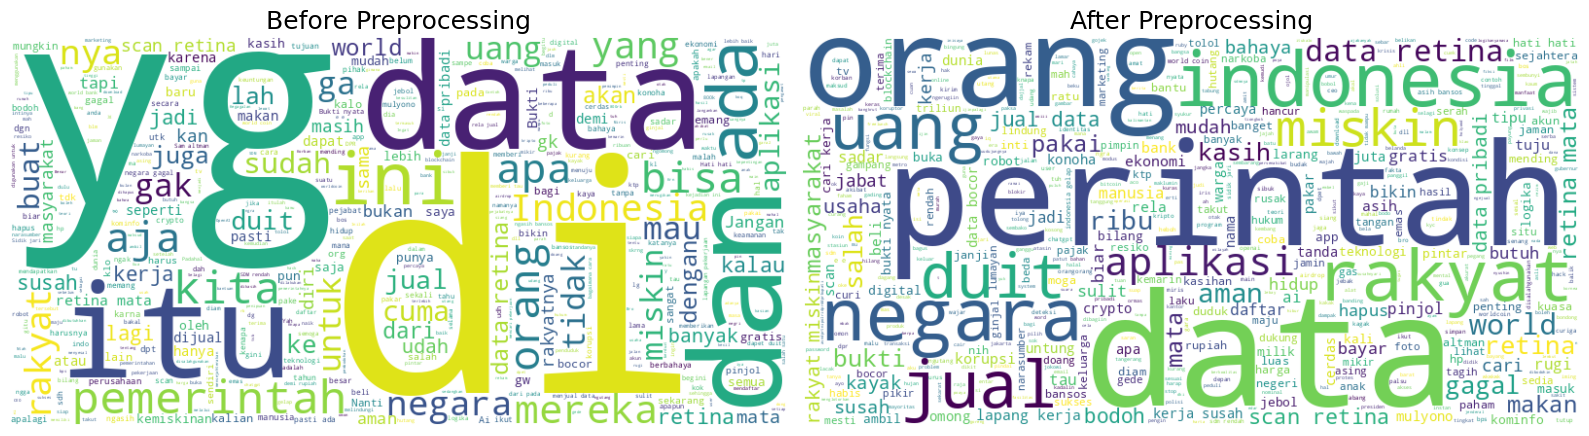

In [23]:
import pandas as pd
import numpy as np
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

# Buat stopwords tambahan
stopwords = set(STOPWORDS)
stopwords.update(['https', 'co', 'RT', '...', 'amp','lu','deh','fyp', 'ya', 'gue', 'sih','update','apk'])

# WordCloud Before (dari kolom 'Review Text')
text_before = ' '.join(data['comment'].astype(str).tolist())
wc_before = WordCloud(stopwords=stopwords, background_color="white", max_words=500, width=800, height=400).generate(text_before)

# WordCloud After (dari kolom 'steming_data')
text_after = ' '.join(data['steming_data'].astype(str).tolist())
wc_after = WordCloud(stopwords=stopwords, background_color="white", max_words=500, width=800, height=400).generate(text_after)

# Visualisasi side-by-side
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.imshow(wc_before, interpolation='bilinear')
plt.axis("off")
plt.title("Before Preprocessing", fontsize=18)

plt.subplot(1, 2, 2)
plt.imshow(wc_after, interpolation='bilinear')
plt.axis("off")
plt.title("After Preprocessing", fontsize=18)

plt.tight_layout()
plt.show()


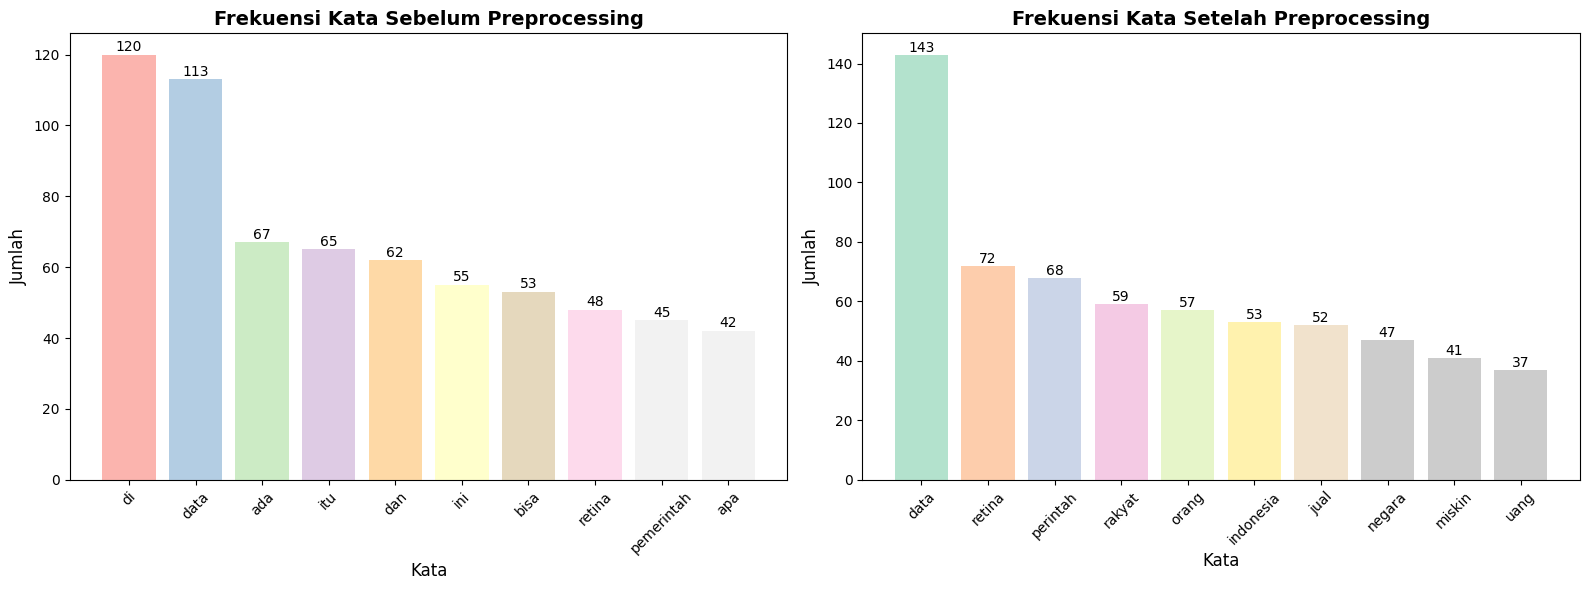

In [24]:
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import STOPWORDS

# Set stopwords tambahan
stopwords = set(STOPWORDS)
stopwords.update(['https', 'co', 'RT', '...', 'amp', 'lu', 'deh', 'fyp', 'ya', 'gue',
                  'sih', 'yg', 'nya', 'aja', 'sdh', 'gak', 'ga','update','apk'])

# BEFORE: kolom 'Review Text'
all_text_before = ' '.join(data["comment"].astype(str))
words_before = all_text_before.split()
filtered_words_before = [word for word in words_before if word.lower() not in stopwords]
word_counts_before = Counter(filtered_words_before)
top_words_before = word_counts_before.most_common(10)
word_before, count_before = zip(*top_words_before)

# AFTER: kolom 'steming_data'
all_text_after = ' '.join(data["steming_data"].astype(str))
words_after = all_text_after.split()
filtered_words_after = [word for word in words_after if word.lower() not in stopwords]
word_counts_after = Counter(filtered_words_after)
top_words_after = word_counts_after.most_common(10)
word_after, count_after = zip(*top_words_after)

# Plot berdampingan
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# BEFORE Plot
colors_before = plt.cm.Pastel1(range(len(word_before)))
bars1 = axes[0].bar(word_before, count_before, color=colors_before)
axes[0].set_title("Frekuensi Kata Sebelum Preprocessing", fontsize=14, fontweight='bold')
axes[0].set_xlabel("Kata", fontsize=12)
axes[0].set_ylabel("Jumlah", fontsize=12)
axes[0].tick_params(axis='x', rotation=45)
for bar, count in zip(bars1, count_before):
    axes[0].text(bar.get_x() + bar.get_width()/2, count + 1, str(count), ha='center')

# AFTER Plot
colors_after = plt.cm.Pastel2(range(len(word_after)))
bars2 = axes[1].bar(word_after, count_after, color=colors_after)
axes[1].set_title("Frekuensi Kata Setelah Preprocessing", fontsize=14, fontweight='bold')
axes[1].set_xlabel("Kata", fontsize=12)
axes[1].set_ylabel("Jumlah", fontsize=12)
axes[1].tick_params(axis='x', rotation=45)
for bar, count in zip(bars2, count_after):
    axes[1].text(bar.get_x() + bar.get_width()/2, count + 1, str(count), ha='center')

plt.tight_layout()
plt.show()


In [25]:
df.to_csv('Hasil_Preprocessing_Data.csv',encoding='utf8', index=False);

# ***PELEBALAN DATA METODE LAXICON BASED***

In [26]:
import pandas as pd

data = pd.read_csv("Hasil_Preprocessing_Data.csv")
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374 entries, 0 to 373
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   comment           374 non-null    object
 1   cleaning          371 non-null    object
 2   case_folding      371 non-null    object
 3   normalisasi       371 non-null    object
 4   tokenize          374 non-null    object
 5   stopword removal  374 non-null    object
 6   steming_data      367 non-null    object
dtypes: object(7)
memory usage: 20.6+ KB


,comment,cleaning,case_folding,normalisasi,tokenize,stopword removal,steming_data
0,RAKYAT MISKIN DI INDONESIA \n90 PERSEN....AKIB...,RAKYAT MISKIN DI INDONESIA \n PERSENAKIBAT DIK...,rakyat miskin di indonesia \n persenakibat dik...,rakyat miskin di indonesia persenakibat dikoru...,"['rakyat', 'miskin', 'di', 'indonesia', 'perse...","['rakyat', 'miskin', 'indonesia', 'persenakiba...",rakyat miskin indonesia persenakibat korupsi a...
1,Gw ikut tuh.. gw percaya Sam altman orang bai...,Gw ikut tuh gw percaya Sam altman orang baik ...,gw ikut tuh gw percaya sam altman orang baik ...,gue ikut tuh gue percaya sama altman orang bai...,"['gue', 'ikut', 'tuh', 'gue', 'percaya', 'sama...","['gue', 'tuh', 'gue', 'percaya', 'altman', 'or...",gue tuh gue percaya altman orang menglotorkan ...
2,Lebay gak berkwalitas berita rendah \nTempat u...,Lebay gak berkwalitas berita rendah \nTempat u...,lebay gak berkwalitas berita rendah \ntempat u...,lebay tidak berkwalitas berita rendah tempat u...,"['lebay', 'tidak', 'berkwalitas', 'berita', 'r...","['lebay', 'berkwalitas', 'berita', 'rendah', '...",lebay berkwalitas berita rendah usaha hibur ma...
3,Metro tv mau bangkrut mau minta jatah sm world 😅,Metro tv mau bangkrut mau minta jatah sm world,metro tv mau bangkrut mau minta jatah sm world,metro tv mau bangkrut mau meminta jatah sama w...,"['metro', 'tv', 'mau', 'bangkrut', 'mau', 'mem...","['metro', 'tv', 'bangkrut', 'jatah', 'world']",metro tv bangkrut jatah world
4,Indonesia Emas 🤣🤣🤣,Indonesia Emas,indonesia emas,indonesia emas,"['indonesia', 'emas']","['indonesia', 'emas']",indonesia emas


In [27]:
data = data.dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 367 entries, 0 to 373
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   comment           367 non-null    object
 1   cleaning          367 non-null    object
 2   case_folding      367 non-null    object
 3   normalisasi       367 non-null    object
 4   tokenize          367 non-null    object
 5   stopword removal  367 non-null    object
 6   steming_data      367 non-null    object
dtypes: object(7)
memory usage: 22.9+ KB


In [28]:
data = pd.DataFrame(data[['steming_data']])
data.head(5)

,steming_data
0,rakyat miskin indonesia persenakibat korupsi a...
1,gue tuh gue percaya altman orang menglotorkan ...
2,lebay berkwalitas berita rendah usaha hibur ma...
3,metro tv bangkrut jatah world
4,indonesia emas


In [29]:
import pandas as pd
import requests

# Unduh kamus leksikon positif dan negatif dari GitHub
positive_url = "https://raw.githubusercontent.com/fajri91/InSet/master/positive.tsv"
negative_url = "https://raw.githubusercontent.com/fajri91/InSet/master/negative.tsv"

positive_lexicon = set(pd.read_csv(positive_url, sep="\t", header=None)[0])
negative_lexicon = set(pd.read_csv(negative_url, sep="\t", header=None)[0])

# Fungsi untuk menentukan sentimen dan menghitung skornya
def determine_sentiment(text):
    if isinstance(text, str):
        positive_count = sum(1 for word in text.split() if word in positive_lexicon)
        negative_count = sum(1 for word in text.split() if word in negative_lexicon)
        sentiment_score = positive_count - negative_count
        if sentiment_score > 0:
            sentiment = "Positif"
        elif sentiment_score < 0:
            sentiment = "Negatif"
        else:
            sentiment = "Netral"
        return sentiment_score, sentiment
    return 0, "Netral"


# Tentukan sentimen dan skor untuk setiap ulasan
data[['Score', 'Sentiment']] = data['steming_data'].apply(lambda x: pd.Series(determine_sentiment(x)))

# Tampilkan hasilnya
data.head(5)


,steming_data,Score,Sentiment
0,rakyat miskin indonesia persenakibat korupsi a...,-2,Negatif
1,gue tuh gue percaya altman orang menglotorkan ...,1,Positif
2,lebay berkwalitas berita rendah usaha hibur ma...,-3,Negatif
3,metro tv bangkrut jatah world,-1,Negatif
4,indonesia emas,0,Netral


/tmp/ipython-input-1910355637.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=sentiment_count.index, y=sentiment_count.values, palette='pastel')


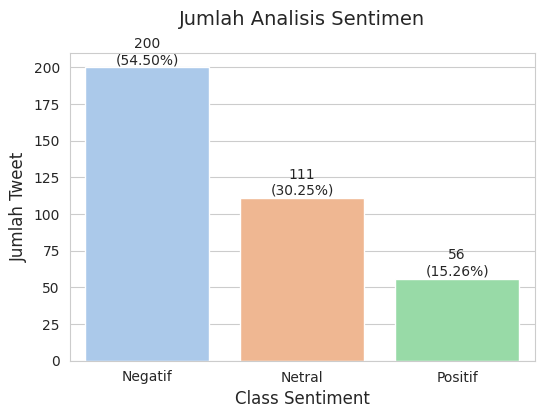

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sentiment_count = data['Sentiment'].value_counts()
sns.set_style('whitegrid')

fig, ax = plt.subplots(figsize=(6, 4))
ax = sns.barplot(x=sentiment_count.index, y=sentiment_count.values, palette='pastel')
plt.title('Jumlah Analisis Sentimen', fontsize=14, pad=20)
plt.xlabel('Class Sentiment', fontsize=12)
plt.ylabel('Jumlah Tweet', fontsize=12)

total = len(data['Sentiment'])

for i, count in enumerate(sentiment_count.values):
    percentage = f'{100 * count / total:.2f}%'
    ax.text(i, count + 0.10, f'{count}\n({percentage})', ha='center', va='bottom')

plt.show()

In [31]:
data.to_csv('Hasil_Labelling_Data.csv',encoding='utf8', index=False)

**WORDCLOUD**

---



In [32]:
import pandas as pd

data = pd.read_csv("Hasil_Labelling_Data.csv")
data.head(5)

,steming_data,Score,Sentiment
0,rakyat miskin indonesia persenakibat korupsi a...,-2,Negatif
1,gue tuh gue percaya altman orang menglotorkan ...,1,Positif
2,lebay berkwalitas berita rendah usaha hibur ma...,-3,Negatif
3,metro tv bangkrut jatah world,-1,Negatif
4,indonesia emas,0,Netral


In [33]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Pisahkan dataset berdasarkan sentimen
sentimen_Neutral = data[data['Sentiment'] == 'Netral']['steming_data'].str.cat(sep=' ')
sentimen_Negative = data[data['Sentiment'] == 'Negatif']['steming_data'].str.cat(sep=' ')
sentimen_Positive = data[data['Sentiment'] == 'Positif']['steming_data'].str.cat(sep=' ')

In [34]:
# Fungsi untuk membuat dan menampilkan WordCloud
def create_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, random_state=42, max_font_size=100, background_color='white').generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

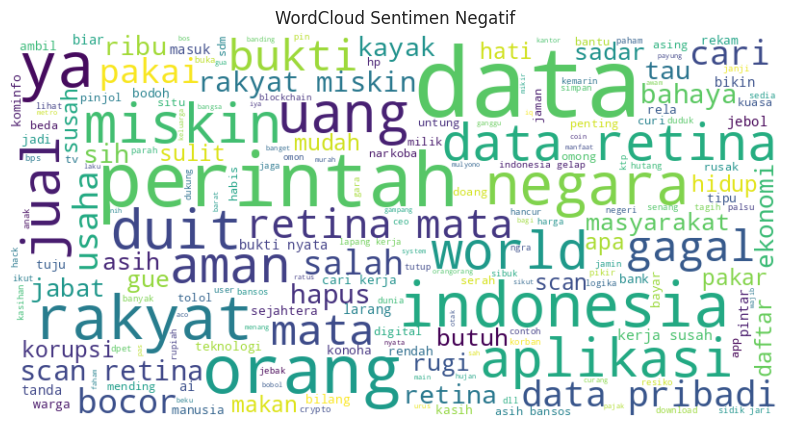

In [35]:
# Membuat WordCloud untuk sentimen Negatif
create_wordcloud(sentimen_Negative, 'WordCloud Sentimen Negatif')

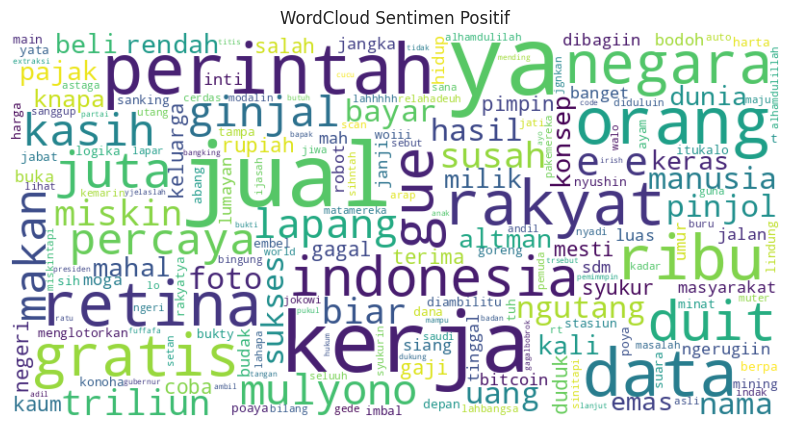

In [36]:
# Membuat WordCloud untuk sentimen Positif
create_wordcloud(sentimen_Positive, 'WordCloud Sentimen Positif')

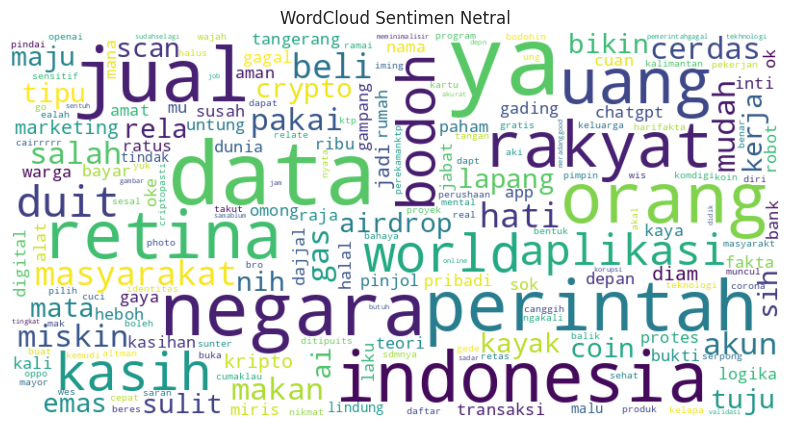

In [37]:
# Membuat WordCloud untuk sentimen Netral
create_wordcloud(sentimen_Neutral, 'WordCloud Sentimen Netral')

# ***SPLITTING DATASET***

In [38]:
import pandas as pd

file_path = 'Hasil_Labelling_Data.csv'
data = pd.read_csv(file_path)

data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 367 entries, 0 to 366
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   steming_data  367 non-null    object
 1   Score         367 non-null    int64 
 2   Sentiment     367 non-null    object
dtypes: int64(1), object(2)
memory usage: 8.7+ KB


,steming_data,Score,Sentiment
0,rakyat miskin indonesia persenakibat korupsi a...,-2,Negatif
1,gue tuh gue percaya altman orang menglotorkan ...,1,Positif
2,lebay berkwalitas berita rendah usaha hibur ma...,-3,Negatif
3,metro tv bangkrut jatah world,-1,Negatif
4,indonesia emas,0,Netral


In [39]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

cleaned_data = data.dropna(subset=['steming_data'])

X = cleaned_data['steming_data']
y = cleaned_data['Sentiment']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Jumlah data latih:", len(X_train))
print("Jumlah data uji:", len(X_test))
print('===========================')



Jumlah data latih: 293
Jumlah data uji: 74


In [40]:
vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

X_train_vec.shape, X_test_vec.shape

((293, 1074), (74, 1074))

In [41]:
# Mencetak bentuk dari X_train_vec dan X_test_vec
print("Shape of X_train_vec:", X_train_vec.shape)
print("Shape of X_test_vec:", X_test_vec.shape)

# Mencetak vektor dari X_train_vec dan X_test_vec
print("\nX_train_vec (as array):")
print(X_train_vec.toarray())

print("\nX_test_vec (as array):")
print(X_test_vec.toarray())

Shape of X_train_vec: (293, 1074)
Shape of X_test_vec: (74, 1074)

X_train_vec (as array):
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

X_test_vec (as array):
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [42]:
import pandas as pd

# Assuming X_train_vec is your csr_matrix
df_X_train_vec = pd.DataFrame(X_train_vec.toarray()) # Convert to DataFrame first

# Now you can save it to a CSV
df_X_train_vec.to_csv('vector.csv', encoding='utf8', index=False)

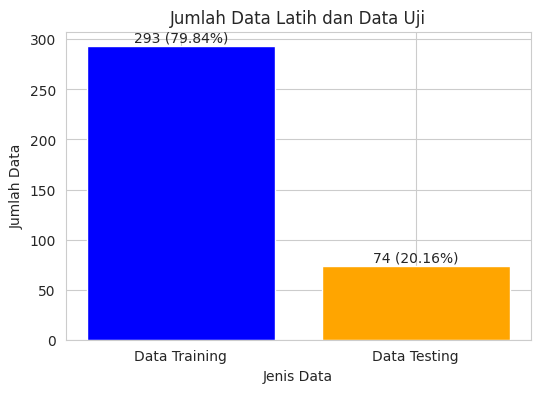

In [43]:
import matplotlib.pyplot as plt


train_size = len(X_train)
test_size = len(X_test)

plt.figure(figsize=(6, 4))
bars = plt.bar(['Data Training', 'Data Testing'], [train_size, test_size], color=['blue', 'orange'])

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 1, f'{height} ({height / (train_size + test_size) * 100:.2f}%)',
             ha='center', va='bottom')

plt.title('Jumlah Data Latih dan Data Uji')
plt.xlabel('Jenis Data')
plt.ylabel('Jumlah Data')
plt.show()

# ***SUPPORT VECTOR MACHINE (SVM)***





In [44]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()

X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

svm = SVC(kernel='linear')
svm.fit(X_train_vectorized, y_train)

y_pred_svm = svm.predict(X_test_vectorized)

labels = data['Sentiment'].unique()

cm_svm = confusion_matrix(y_test, y_pred_svm, labels=labels)
print("SVM Confusion Matrix:")
print(cm_svm)

SVM Confusion Matrix:
[[31  0  9]
 [ 1  3  7]
 [ 3  2 18]]


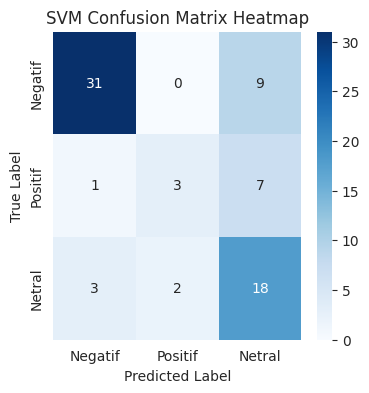

In [45]:
# --- Heatmap Visualization ---
plt.figure(figsize=(4, 4))
sns.heatmap(cm_svm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels)
plt.title("SVM Confusion Matrix Heatmap")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [46]:
# Perhitungan akurasi
accuracy = accuracy_score(y_test, y_pred_svm)
print("Accuracy:", accuracy)
print("")

accuracy_svm_percentage = accuracy * 100
print("SVM Accuracy:", "{:.2f}%".format(accuracy_svm_percentage))
print("")

# Laporan klasifikasi
classification_rep = classification_report(y_test, y_pred_svm)
print("Classification Report:")
print(classification_rep)

Accuracy: 0.7027027027027027

SVM Accuracy: 70.27%

Classification Report:
              precision    recall  f1-score   support

     Negatif       0.89      0.78      0.83        40
      Netral       0.53      0.78      0.63        23
     Positif       0.60      0.27      0.38        11

    accuracy                           0.70        74
   macro avg       0.67      0.61      0.61        74
weighted avg       0.73      0.70      0.70        74



In [47]:
import pandas as pd

# Buat DataFrame hasil prediksi
df = pd.DataFrame({
    'steming_data': X_test,
    'Actual': y_test,
    'Predicted': y_pred_svm
})

df.to_csv('Hasil_pred_SVM.csv',encoding='utf8', index=False)

# Tampilkan DataFrame
df.head(20)


,steming_data,Actual,Predicted
177,selagi izin perintah retina bahaya data tipu,Negatif,Negatif
336,konspirasi barat aman negara deteksi akurat or...,Negatif,Netral
288,rumah dc pinjol bela uang ribu ogahh,Positif,Netral
157,bukti nyata perintah pengin rakyat cerdas pint...,Negatif,Negatif
331,ya pojok butuh uang hidup anak istri pmrintah ...,Negatif,Negatif
276,world app beku fikirin susah rakyat masyarakat...,Negatif,Negatif
222,biasa kaum bansos orang normal curiga,Positif,Netral
78,mak aki data retina ya go oppo wes cairrrrr,Netral,Netral
14,world buka kalimantan,Netral,Negatif
192,retina salah data,Negatif,Negatif


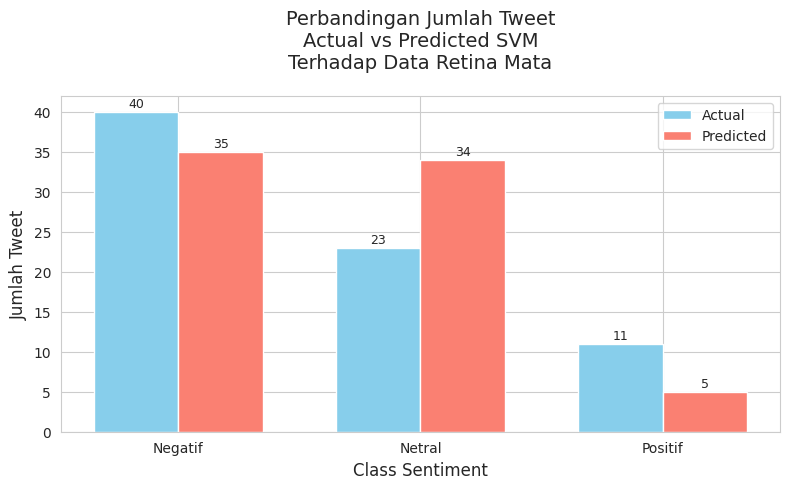

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

predicted_counts = df['Predicted'].value_counts().sort_index()
actual_counts = df['Actual'].value_counts().sort_index()

comparison_df = pd.DataFrame({
    'Actual': actual_counts,
    'Predicted': predicted_counts
}).fillna(0)

# Buat plot
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(8, 5))

bar_width = 0.35
index = range(len(comparison_df))

# Plot Actual
ax.bar([i - bar_width/2 for i in index], comparison_df['Actual'], width=bar_width, label='Actual', color='skyblue')

# Plot Predicted
ax.bar([i + bar_width/2 for i in index], comparison_df['Predicted'], width=bar_width, label='Predicted', color='salmon')

# Set label dan title
ax.set_xlabel('Class Sentiment', fontsize=12)
ax.set_ylabel('Jumlah Tweet', fontsize=12)
ax.set_title('Perbandingan Jumlah Tweet\nActual vs Predicted SVM\nTerhadap Data Retina Mata', fontsize=14, pad=20)
ax.set_xticks(index)
ax.set_xticklabels(comparison_df.index)
ax.legend()

# Tambahkan jumlah di atas bar
for i in index:
    actual = comparison_df['Actual'].iloc[i]
    predicted = comparison_df['Predicted'].iloc[i]
    ax.text(i - bar_width/2, actual + 0.2, int(actual), ha='center', va='bottom', fontsize=9)
    ax.text(i + bar_width/2, predicted + 0.2, int(predicted), ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()
